In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [32]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

In [33]:
def preprocess_data_columns(df, columns):
    df = df[columns].fillna(df.mean())  #Fill NaN values with the mean of the column
    return df

def preprocess_data(df):
    # Drop the 'Year' column if it exists
    # df = df.drop(columns=['Year'], errors='ignore')

    # Fill NaN values with the mean of the column
    df = df.fillna(df.mean())

    # Replace inf/-inf with NaN and then drop them
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert all data to float32 for compatibility with TensorFlow
    df = df.astype(np.float32)

    return df

def create_sequences(data, n_steps_in, n_steps_out):
    # Create sequences for LSTM input
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        seq_x, seq_y = data[i:(i+n_steps_in), :-1], data[(i+n_steps_in):(i+n_steps_in+n_steps_out), -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [34]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=input_shape, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=100, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=50, return_sequences=False, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(62, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

In [35]:
def plot_predictions(train_years, test_years, train_data, test_data, predicted):
    plt.figure(figsize=(16, 8))
    plt.plot(train_years, train_data, color='blue', label='Training set (Before last 5 years)')
    plt.plot(test_years, test_data, color='red', label='Test set (Last 5 years and beyond)')
    plt.plot(test_years, predicted, color='orange', label='Predicted Olive Yield')
    plt.title('Olive Yield Prediction')
    plt.xlabel('Year')
    plt.ylabel('Yield Olives')

    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))  # Show a year tick every 1 year
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))  # Show a minor tick every half year

    plt.xticks(rotation=45)

    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [36]:
def plot_loss_and_mae(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history.history['loss'], label='Training MSE', color='blue')
    if 'val_loss' in history.history:
        ax1.plot(history.history['val_loss'], label='Validation MSE', color='orange')
    ax1.set_title('Model MSE Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(history.history['mae'], label='Training MAE', color='blue')
    if 'val_mae' in history.history:
        ax2.plot(history.history['val_mae'], label='Validation MAE', color='orange')
    ax2.set_title('Model MAE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.legend()
    plt.show()

In [37]:
#schedukler
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))

    return LearningRateScheduler(schedule)

               T    TM    Tm      PP     V  RA  SN  TS  FG  TN  GR  \
Year                                                                 
2012-01-01  18.2  23.9  13.1  532.64  12.8  92   1  15  10   0   0   
2012-01-02  18.2  23.9  13.1  532.64  12.8  92   1  15  10   0   0   
2012-01-03  18.2  23.9  13.1  532.64  12.8  92   1  15  10   0   0   
2012-01-04  18.2  23.9  13.1  532.64  12.8  92   1  15  10   0   0   
2012-01-05  18.2  23.9  13.1  532.64  12.8  92   1  15  10   0   0   

            Areas_Blé_dur  Production_Blé_dur  Yields_Blé_dur  Areas_olives  \
Year                                                                          
2012-01-01        13087.0              270000           20.63           NaN   
2012-01-02        13087.0              270000           20.63           NaN   
2012-01-03        13087.0              270000           20.63           NaN   
2012-01-04        13087.0              270000           20.63           NaN   
2012-01-05        13087.0          

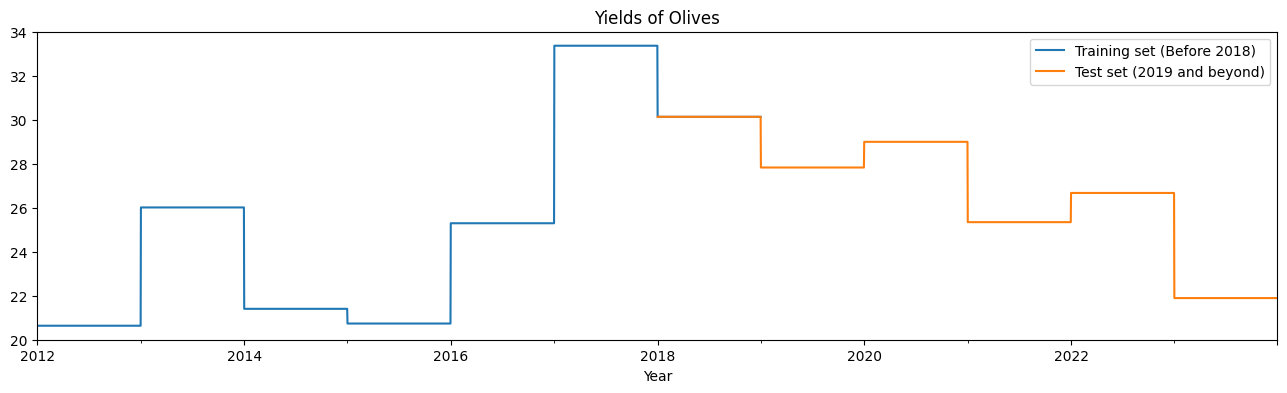

In [54]:
dataset = pd.read_csv('TEST3.csv', index_col='Year', parse_dates=['Year'])


print(dataset.head())

# Filter the dataset for the training set to include years before 2018
training_set = dataset[dataset.index.year <= 2018]['Yields_Blé_dur']
# Filter the dataset for the test set to include years from 2019 onwards
test_set = dataset[dataset.index.year >= 2018]['Yields_Blé_dur']

# Plotting 'Yields_olives' for the training set
training_set.plot(figsize=(16,4), legend=True)

# Plotting 'Yields_olives' for the test set
test_set.plot(figsize=(16,4), legend=True)


plt.legend(['Training set (Before 2018)', 'Test set (2019 and beyond)'])
plt.title('Yields of Olives')
plt.show()

In [52]:
file_path = 'TEST3.csv'  # Update the path to your CSV file

columns = ['Year','T', 'TM', 'Tm', 'PP', 'Yields_Blé_dur']
n_steps_in, n_steps_out = 3, 1
test_set_years = 5


df = load_data(file_path)

# Preprocess the data
df_processed = preprocess_data_columns(df, columns)
# Extract 'Year' for plotting purposes
years = df_processed['Year'].values

# Drop the 'Year' column before LSTM processing
df_processed = df_processed.drop(columns=['Year'], errors='ignore')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_processed.drop('Yields_olives', axis=1))

# Separate scaler for the Yield_Olives
yield_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_yield = yield_scaler.fit_transform(df_processed[['Yields_olives']])

# Combine the scaled data with the scaled Yield_Olives
scaled_data = np.concatenate((scaled_data, scaled_yield), axis=1)

# Split the data into training and testing sets
training_data = scaled_data[:-test_set_years]
testing_data = scaled_data[-(n_steps_in+test_set_years):]

# Split years for plotting
train_years = years[:-test_set_years]
test_years = years[-test_set_years:]

# Prepare the data for LSTM
X_train, y_train = create_sequences(training_data, n_steps_in, n_steps_out)
X_test, y_test = create_sequences(testing_data, n_steps_in, n_steps_out)

# Reshape input data to be 3D [samples, timesteps, features] for LSTM
n_features = X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_steps_in, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps_in, n_features))

TypeError: Could not convert ['1/1/20121/2/20121/3/20121/4/20121/5/20121/6/20121/7/20121/8/20121/9/20121/10/20121/11/20121/12/20121/13/20121/14/20121/15/20121/16/20121/17/20121/18/20121/19/20121/20/20121/21/20121/22/20121/23/20121/24/20121/25/20121/26/20121/27/20121/28/20121/29/20121/30/20121/31/20122/1/20122/2/20122/3/20122/4/20122/5/20122/6/20122/7/20122/8/20122/9/20122/10/20122/11/20122/12/20122/13/20122/14/20122/15/20122/16/20122/17/20122/18/20122/19/20122/20/20122/21/20122/22/20122/23/20122/24/20122/25/20122/26/20122/27/20122/28/20122/29/20123/1/20123/2/20123/3/20123/4/20123/5/20123/6/20123/7/20123/8/20123/9/20123/10/20123/11/20123/12/20123/13/20123/14/20123/15/20123/16/20123/17/20123/18/20123/19/20123/20/20123/21/20123/22/20123/23/20123/24/20123/25/20123/26/20123/27/20123/28/20123/29/20123/30/20123/31/20124/1/20124/2/20124/3/20124/4/20124/5/20124/6/20124/7/20124/8/20124/9/20124/10/20124/11/20124/12/20124/13/20124/14/20124/15/20124/16/20124/17/20124/18/20124/19/20124/20/20124/21/20124/22/20124/23/20124/24/20124/25/20124/26/20124/27/20124/28/20124/29/20124/30/20125/1/20125/2/20125/3/20125/4/20125/5/20125/6/20125/7/20125/8/20125/9/20125/10/20125/11/20125/12/20125/13/20125/14/20125/15/20125/16/20125/17/20125/18/20125/19/20125/20/20125/21/20125/22/20125/23/20125/24/20125/25/20125/26/20125/27/20125/28/20125/29/20125/30/20125/31/20126/1/20126/2/20126/3/20126/4/20126/5/20126/6/20126/7/20126/8/20126/9/20126/10/20126/11/20126/12/20126/13/20126/14/20126/15/20126/16/20126/17/20126/18/20126/19/20126/20/20126/21/20126/22/20126/23/20126/24/20126/25/20126/26/20126/27/20126/28/20126/29/20126/30/20127/1/20127/2/20127/3/20127/4/20127/5/20127/6/20127/7/20127/8/20127/9/20127/10/20127/11/20127/12/20127/13/20127/14/20127/15/20127/16/20127/17/20127/18/20127/19/20127/20/20127/21/20127/22/20127/23/20127/24/20127/25/20127/26/20127/27/20127/28/20127/29/20127/30/20127/31/20128/1/20128/2/20128/3/20128/4/20128/5/20128/6/20128/7/20128/8/20128/9/20128/10/20128/11/20128/12/20128/13/20128/14/20128/15/20128/16/20128/17/20128/18/20128/19/20128/20/20128/21/20128/22/20128/23/20128/24/20128/25/20128/26/20128/27/20128/28/20128/29/20128/30/20128/31/20129/1/20129/2/20129/3/20129/4/20129/5/20129/6/20129/7/20129/8/20129/9/20129/10/20129/11/20129/12/20129/13/20129/14/20129/15/20129/16/20129/17/20129/18/20129/19/20129/20/20129/21/20129/22/20129/23/20129/24/20129/25/20129/26/20129/27/20129/28/20129/29/20129/30/201210/1/201210/2/201210/3/201210/4/201210/5/201210/6/201210/7/201210/8/201210/9/201210/10/201210/11/201210/12/201210/13/201210/14/201210/15/201210/16/201210/17/201210/18/201210/19/201210/20/201210/21/201210/22/201210/23/201210/24/201210/25/201210/26/201210/27/201210/28/201210/29/201210/30/201210/31/201211/1/201211/2/201211/3/201211/4/201211/5/201211/6/201211/7/201211/8/201211/9/201211/10/201211/11/201211/12/201211/13/201211/14/201211/15/201211/16/201211/17/201211/18/201211/19/201211/20/201211/21/201211/22/201211/23/201211/24/201211/25/201211/26/201211/27/201211/28/201211/29/201211/30/201212/1/201212/2/201212/3/201212/4/201212/5/201212/6/201212/7/201212/8/201212/9/201212/10/201212/11/201212/12/201212/13/201212/14/201212/15/201212/16/201212/17/201212/18/201212/19/201212/20/201212/21/201212/22/201212/23/201212/24/201212/25/201212/26/201212/27/201212/28/201212/29/201212/30/201212/31/20121/1/20131/2/20131/3/20131/4/20131/5/20131/6/20131/7/20131/8/20131/9/20131/10/20131/11/20131/12/20131/13/20131/14/20131/15/20131/16/20131/17/20131/18/20131/19/20131/20/20131/21/20131/22/20131/23/20131/24/20131/25/20131/26/20131/27/20131/28/20131/29/20131/30/20131/31/20132/1/20132/2/20132/3/20132/4/20132/5/20132/6/20132/7/20132/8/20132/9/20132/10/20132/11/20132/12/20132/13/20132/14/20132/15/20132/16/20132/17/20132/18/20132/19/20132/20/20132/21/20132/22/20132/23/20132/24/20132/25/20132/26/20132/27/20132/28/20133/1/20133/2/20133/3/20133/4/20133/5/20133/6/20133/7/20133/8/20133/9/20133/10/20133/11/20133/12/20133/13/20133/14/20133/15/20133/16/20133/17/20133/18/20133/19/20133/20/20133/21/20133/22/20133/23/20133/24/20133/25/20133/26/20133/27/20133/28/20133/29/20133/30/20133/31/20134/1/20134/2/20134/3/20134/4/20134/5/20134/6/20134/7/20134/8/20134/9/20134/10/20134/11/20134/12/20134/13/20134/14/20134/15/20134/16/20134/17/20134/18/20134/19/20134/20/20134/21/20134/22/20134/23/20134/24/20134/25/20134/26/20134/27/20134/28/20134/29/20134/30/20135/1/20135/2/20135/3/20135/4/20135/5/20135/6/20135/7/20135/8/20135/9/20135/10/20135/11/20135/12/20135/13/20135/14/20135/15/20135/16/20135/17/20135/18/20135/19/20135/20/20135/21/20135/22/20135/23/20135/24/20135/25/20135/26/20135/27/20135/28/20135/29/20135/30/20135/31/20136/1/20136/2/20136/3/20136/4/20136/5/20136/6/20136/7/20136/8/20136/9/20136/10/20136/11/20136/12/20136/13/20136/14/20136/15/20136/16/20136/17/20136/18/20136/19/20136/20/20136/21/20136/22/20136/23/20136/24/20136/25/20136/26/20136/27/20136/28/20136/29/20136/30/20137/1/20137/2/20137/3/20137/4/20137/5/20137/6/20137/7/20137/8/20137/9/20137/10/20137/11/20137/12/20137/13/20137/14/20137/15/20137/16/20137/17/20137/18/20137/19/20137/20/20137/21/20137/22/20137/23/20137/24/20137/25/20137/26/20137/27/20137/28/20137/29/20137/30/20137/31/20138/1/20138/2/20138/3/20138/4/20138/5/20138/6/20138/7/20138/8/20138/9/20138/10/20138/11/20138/12/20138/13/20138/14/20138/15/20138/16/20138/17/20138/18/20138/19/20138/20/20138/21/20138/22/20138/23/20138/24/20138/25/20138/26/20138/27/20138/28/20138/29/20138/30/20138/31/20139/1/20139/2/20139/3/20139/4/20139/5/20139/6/20139/7/20139/8/20139/9/20139/10/20139/11/20139/12/20139/13/20139/14/20139/15/20139/16/20139/17/20139/18/20139/19/20139/20/20139/21/20139/22/20139/23/20139/24/20139/25/20139/26/20139/27/20139/28/20139/29/20139/30/201310/1/201310/2/201310/3/201310/4/201310/5/201310/6/201310/7/201310/8/201310/9/201310/10/201310/11/201310/12/201310/13/201310/14/201310/15/201310/16/201310/17/201310/18/201310/19/201310/20/201310/21/201310/22/201310/23/201310/24/201310/25/201310/26/201310/27/201310/28/201310/29/201310/30/201310/31/201311/1/201311/2/201311/3/201311/4/201311/5/201311/6/201311/7/201311/8/201311/9/201311/10/201311/11/201311/12/201311/13/201311/14/201311/15/201311/16/201311/17/201311/18/201311/19/201311/20/201311/21/201311/22/201311/23/201311/24/201311/25/201311/26/201311/27/201311/28/201311/29/201311/30/201312/1/201312/2/201312/3/201312/4/201312/5/201312/6/201312/7/201312/8/201312/9/201312/10/201312/11/201312/12/201312/13/201312/14/201312/15/201312/16/201312/17/201312/18/201312/19/201312/20/201312/21/201312/22/201312/23/201312/24/201312/25/201312/26/201312/27/201312/28/201312/29/201312/30/201312/31/20131/1/20141/2/20141/3/20141/4/20141/5/20141/6/20141/7/20141/8/20141/9/20141/10/20141/11/20141/12/20141/13/20141/14/20141/15/20141/16/20141/17/20141/18/20141/19/20141/20/20141/21/20141/22/20141/23/20141/24/20141/25/20141/26/20141/27/20141/28/20141/29/20141/30/20141/31/20142/1/20142/2/20142/3/20142/4/20142/5/20142/6/20142/7/20142/8/20142/9/20142/10/20142/11/20142/12/20142/13/20142/14/20142/15/20142/16/20142/17/20142/18/20142/19/20142/20/20142/21/20142/22/20142/23/20142/24/20142/25/20142/26/20142/27/20142/28/20143/1/20143/2/20143/3/20143/4/20143/5/20143/6/20143/7/20143/8/20143/9/20143/10/20143/11/20143/12/20143/13/20143/14/20143/15/20143/16/20143/17/20143/18/20143/19/20143/20/20143/21/20143/22/20143/23/20143/24/20143/25/20143/26/20143/27/20143/28/20143/29/20143/30/20143/31/20144/1/20144/2/20144/3/20144/4/20144/5/20144/6/20144/7/20144/8/20144/9/20144/10/20144/11/20144/12/20144/13/20144/14/20144/15/20144/16/20144/17/20144/18/20144/19/20144/20/20144/21/20144/22/20144/23/20144/24/20144/25/20144/26/20144/27/20144/28/20144/29/20144/30/20145/1/20145/2/20145/3/20145/4/20145/5/20145/6/20145/7/20145/8/20145/9/20145/10/20145/11/20145/12/20145/13/20145/14/20145/15/20145/16/20145/17/20145/18/20145/19/20145/20/20145/21/20145/22/20145/23/20145/24/20145/25/20145/26/20145/27/20145/28/20145/29/20145/30/20145/31/20146/1/20146/2/20146/3/20146/4/20146/5/20146/6/20146/7/20146/8/20146/9/20146/10/20146/11/20146/12/20146/13/20146/14/20146/15/20146/16/20146/17/20146/18/20146/19/20146/20/20146/21/20146/22/20146/23/20146/24/20146/25/20146/26/20146/27/20146/28/20146/29/20146/30/20147/1/20147/2/20147/3/20147/4/20147/5/20147/6/20147/7/20147/8/20147/9/20147/10/20147/11/20147/12/20147/13/20147/14/20147/15/20147/16/20147/17/20147/18/20147/19/20147/20/20147/21/20147/22/20147/23/20147/24/20147/25/20147/26/20147/27/20147/28/20147/29/20147/30/20147/31/20148/1/20148/2/20148/3/20148/4/20148/5/20148/6/20148/7/20148/8/20148/9/20148/10/20148/11/20148/12/20148/13/20148/14/20148/15/20148/16/20148/17/20148/18/20148/19/20148/20/20148/21/20148/22/20148/23/20148/24/20148/25/20148/26/20148/27/20148/28/20148/29/20148/30/20148/31/20149/1/20149/2/20149/3/20149/4/20149/5/20149/6/20149/7/20149/8/20149/9/20149/10/20149/11/20149/12/20149/13/20149/14/20149/15/20149/16/20149/17/20149/18/20149/19/20149/20/20149/21/20149/22/20149/23/20149/24/20149/25/20149/26/20149/27/20149/28/20149/29/20149/30/201410/1/201410/2/201410/3/201410/4/201410/5/201410/6/201410/7/201410/8/201410/9/201410/10/201410/11/201410/12/201410/13/201410/14/201410/15/201410/16/201410/17/201410/18/201410/19/201410/20/201410/21/201410/22/201410/23/201410/24/201410/25/201410/26/201410/27/201410/28/201410/29/201410/30/201410/31/201411/1/201411/2/201411/3/201411/4/201411/5/201411/6/201411/7/201411/8/201411/9/201411/10/201411/11/201411/12/201411/13/201411/14/201411/15/201411/16/201411/17/201411/18/201411/19/201411/20/201411/21/201411/22/201411/23/201411/24/201411/25/201411/26/201411/27/201411/28/201411/29/201411/30/201412/1/201412/2/201412/3/201412/4/201412/5/201412/6/201412/7/201412/8/201412/9/201412/10/201412/11/201412/12/201412/13/201412/14/201412/15/201412/16/201412/17/201412/18/201412/19/201412/20/201412/21/201412/22/201412/23/201412/24/201412/25/201412/26/201412/27/201412/28/201412/29/201412/30/201412/31/20141/1/20151/2/20151/3/20151/4/20151/5/20151/6/20151/7/20151/8/20151/9/20151/10/20151/11/20151/12/20151/13/20151/14/20151/15/20151/16/20151/17/20151/18/20151/19/20151/20/20151/21/20151/22/20151/23/20151/24/20151/25/20151/26/20151/27/20151/28/20151/29/20151/30/20151/31/20152/1/20152/2/20152/3/20152/4/20152/5/20152/6/20152/7/20152/8/20152/9/20152/10/20152/11/20152/12/20152/13/20152/14/20152/15/20152/16/20152/17/20152/18/20152/19/20152/20/20152/21/20152/22/20152/23/20152/24/20152/25/20152/26/20152/27/20152/28/20153/1/20153/2/20153/3/20153/4/20153/5/20153/6/20153/7/20153/8/20153/9/20153/10/20153/11/20153/12/20153/13/20153/14/20153/15/20153/16/20153/17/20153/18/20153/19/20153/20/20153/21/20153/22/20153/23/20153/24/20153/25/20153/26/20153/27/20153/28/20153/29/20153/30/20153/31/20154/1/20154/2/20154/3/20154/4/20154/5/20154/6/20154/7/20154/8/20154/9/20154/10/20154/11/20154/12/20154/13/20154/14/20154/15/20154/16/20154/17/20154/18/20154/19/20154/20/20154/21/20154/22/20154/23/20154/24/20154/25/20154/26/20154/27/20154/28/20154/29/20154/30/20155/1/20155/2/20155/3/20155/4/20155/5/20155/6/20155/7/20155/8/20155/9/20155/10/20155/11/20155/12/20155/13/20155/14/20155/15/20155/16/20155/17/20155/18/20155/19/20155/20/20155/21/20155/22/20155/23/20155/24/20155/25/20155/26/20155/27/20155/28/20155/29/20155/30/20155/31/20156/1/20156/2/20156/3/20156/4/20156/5/20156/6/20156/7/20156/8/20156/9/20156/10/20156/11/20156/12/20156/13/20156/14/20156/15/20156/16/20156/17/20156/18/20156/19/20156/20/20156/21/20156/22/20156/23/20156/24/20156/25/20156/26/20156/27/20156/28/20156/29/20156/30/20157/1/20157/2/20157/3/20157/4/20157/5/20157/6/20157/7/20157/8/20157/9/20157/10/20157/11/20157/12/20157/13/20157/14/20157/15/20157/16/20157/17/20157/18/20157/19/20157/20/20157/21/20157/22/20157/23/20157/24/20157/25/20157/26/20157/27/20157/28/20157/29/20157/30/20157/31/20158/1/20158/2/20158/3/20158/4/20158/5/20158/6/20158/7/20158/8/20158/9/20158/10/20158/11/20158/12/20158/13/20158/14/20158/15/20158/16/20158/17/20158/18/20158/19/20158/20/20158/21/20158/22/20158/23/20158/24/20158/25/20158/26/20158/27/20158/28/20158/29/20158/30/20158/31/20159/1/20159/2/20159/3/20159/4/20159/5/20159/6/20159/7/20159/8/20159/9/20159/10/20159/11/20159/12/20159/13/20159/14/20159/15/20159/16/20159/17/20159/18/20159/19/20159/20/20159/21/20159/22/20159/23/20159/24/20159/25/20159/26/20159/27/20159/28/20159/29/20159/30/201510/1/201510/2/201510/3/201510/4/201510/5/201510/6/201510/7/201510/8/201510/9/201510/10/201510/11/201510/12/201510/13/201510/14/201510/15/201510/16/201510/17/201510/18/201510/19/201510/20/201510/21/201510/22/201510/23/201510/24/201510/25/201510/26/201510/27/201510/28/201510/29/201510/30/201510/31/201511/1/201511/2/201511/3/201511/4/201511/5/201511/6/201511/7/201511/8/201511/9/201511/10/201511/11/201511/12/201511/13/201511/14/201511/15/201511/16/201511/17/201511/18/201511/19/201511/20/201511/21/201511/22/201511/23/201511/24/201511/25/201511/26/201511/27/201511/28/201511/29/201511/30/201512/1/201512/2/201512/3/201512/4/201512/5/201512/6/201512/7/201512/8/201512/9/201512/10/201512/11/201512/12/201512/13/201512/14/201512/15/201512/16/201512/17/201512/18/201512/19/201512/20/201512/21/201512/22/201512/23/201512/24/201512/25/201512/26/201512/27/201512/28/201512/29/201512/30/201512/31/20151/1/20161/2/20161/3/20161/4/20161/5/20161/6/20161/7/20161/8/20161/9/20161/10/20161/11/20161/12/20161/13/20161/14/20161/15/20161/16/20161/17/20161/18/20161/19/20161/20/20161/21/20161/22/20161/23/20161/24/20161/25/20161/26/20161/27/20161/28/20161/29/20161/30/20161/31/20162/1/20162/2/20162/3/20162/4/20162/5/20162/6/20162/7/20162/8/20162/9/20162/10/20162/11/20162/12/20162/13/20162/14/20162/15/20162/16/20162/17/20162/18/20162/19/20162/20/20162/21/20162/22/20162/23/20162/24/20162/25/20162/26/20162/27/20162/28/20162/29/20163/1/20163/2/20163/3/20163/4/20163/5/20163/6/20163/7/20163/8/20163/9/20163/10/20163/11/20163/12/20163/13/20163/14/20163/15/20163/16/20163/17/20163/18/20163/19/20163/20/20163/21/20163/22/20163/23/20163/24/20163/25/20163/26/20163/27/20163/28/20163/29/20163/30/20163/31/20164/1/20164/2/20164/3/20164/4/20164/5/20164/6/20164/7/20164/8/20164/9/20164/10/20164/11/20164/12/20164/13/20164/14/20164/15/20164/16/20164/17/20164/18/20164/19/20164/20/20164/21/20164/22/20164/23/20164/24/20164/25/20164/26/20164/27/20164/28/20164/29/20164/30/20165/1/20165/2/20165/3/20165/4/20165/5/20165/6/20165/7/20165/8/20165/9/20165/10/20165/11/20165/12/20165/13/20165/14/20165/15/20165/16/20165/17/20165/18/20165/19/20165/20/20165/21/20165/22/20165/23/20165/24/20165/25/20165/26/20165/27/20165/28/20165/29/20165/30/20165/31/20166/1/20166/2/20166/3/20166/4/20166/5/20166/6/20166/7/20166/8/20166/9/20166/10/20166/11/20166/12/20166/13/20166/14/20166/15/20166/16/20166/17/20166/18/20166/19/20166/20/20166/21/20166/22/20166/23/20166/24/20166/25/20166/26/20166/27/20166/28/20166/29/20166/30/20167/1/20167/2/20167/3/20167/4/20167/5/20167/6/20167/7/20167/8/20167/9/20167/10/20167/11/20167/12/20167/13/20167/14/20167/15/20167/16/20167/17/20167/18/20167/19/20167/20/20167/21/20167/22/20167/23/20167/24/20167/25/20167/26/20167/27/20167/28/20167/29/20167/30/20167/31/20168/1/20168/2/20168/3/20168/4/20168/5/20168/6/20168/7/20168/8/20168/9/20168/10/20168/11/20168/12/20168/13/20168/14/20168/15/20168/16/20168/17/20168/18/20168/19/20168/20/20168/21/20168/22/20168/23/20168/24/20168/25/20168/26/20168/27/20168/28/20168/29/20168/30/20168/31/20169/1/20169/2/20169/3/20169/4/20169/5/20169/6/20169/7/20169/8/20169/9/20169/10/20169/11/20169/12/20169/13/20169/14/20169/15/20169/16/20169/17/20169/18/20169/19/20169/20/20169/21/20169/22/20169/23/20169/24/20169/25/20169/26/20169/27/20169/28/20169/29/20169/30/201610/1/201610/2/201610/3/201610/4/201610/5/201610/6/201610/7/201610/8/201610/9/201610/10/201610/11/201610/12/201610/13/201610/14/201610/15/201610/16/201610/17/201610/18/201610/19/201610/20/201610/21/201610/22/201610/23/201610/24/201610/25/201610/26/201610/27/201610/28/201610/29/201610/30/201610/31/201611/1/201611/2/201611/3/201611/4/201611/5/201611/6/201611/7/201611/8/201611/9/201611/10/201611/11/201611/12/201611/13/201611/14/201611/15/201611/16/201611/17/201611/18/201611/19/201611/20/201611/21/201611/22/201611/23/201611/24/201611/25/201611/26/201611/27/201611/28/201611/29/201611/30/201612/1/201612/2/201612/3/201612/4/201612/5/201612/6/201612/7/201612/8/201612/9/201612/10/201612/11/201612/12/201612/13/201612/14/201612/15/201612/16/201612/17/201612/18/201612/19/201612/20/201612/21/201612/22/201612/23/201612/24/201612/25/201612/26/201612/27/201612/28/201612/29/201612/30/201612/31/20161/1/20171/2/20171/3/20171/4/20171/5/20171/6/20171/7/20171/8/20171/9/20171/10/20171/11/20171/12/20171/13/20171/14/20171/15/20171/16/20171/17/20171/18/20171/19/20171/20/20171/21/20171/22/20171/23/20171/24/20171/25/20171/26/20171/27/20171/28/20171/29/20171/30/20171/31/20172/1/20172/2/20172/3/20172/4/20172/5/20172/6/20172/7/20172/8/20172/9/20172/10/20172/11/20172/12/20172/13/20172/14/20172/15/20172/16/20172/17/20172/18/20172/19/20172/20/20172/21/20172/22/20172/23/20172/24/20172/25/20172/26/20172/27/20172/28/20173/1/20173/2/20173/3/20173/4/20173/5/20173/6/20173/7/20173/8/20173/9/20173/10/20173/11/20173/12/20173/13/20173/14/20173/15/20173/16/20173/17/20173/18/20173/19/20173/20/20173/21/20173/22/20173/23/20173/24/20173/25/20173/26/20173/27/20173/28/20173/29/20173/30/20173/31/20174/1/20174/2/20174/3/20174/4/20174/5/20174/6/20174/7/20174/8/20174/9/20174/10/20174/11/20174/12/20174/13/20174/14/20174/15/20174/16/20174/17/20174/18/20174/19/20174/20/20174/21/20174/22/20174/23/20174/24/20174/25/20174/26/20174/27/20174/28/20174/29/20174/30/20175/1/20175/2/20175/3/20175/4/20175/5/20175/6/20175/7/20175/8/20175/9/20175/10/20175/11/20175/12/20175/13/20175/14/20175/15/20175/16/20175/17/20175/18/20175/19/20175/20/20175/21/20175/22/20175/23/20175/24/20175/25/20175/26/20175/27/20175/28/20175/29/20175/30/20175/31/20176/1/20176/2/20176/3/20176/4/20176/5/20176/6/20176/7/20176/8/20176/9/20176/10/20176/11/20176/12/20176/13/20176/14/20176/15/20176/16/20176/17/20176/18/20176/19/20176/20/20176/21/20176/22/20176/23/20176/24/20176/25/20176/26/20176/27/20176/28/20176/29/20176/30/20177/1/20177/2/20177/3/20177/4/20177/5/20177/6/20177/7/20177/8/20177/9/20177/10/20177/11/20177/12/20177/13/20177/14/20177/15/20177/16/20177/17/20177/18/20177/19/20177/20/20177/21/20177/22/20177/23/20177/24/20177/25/20177/26/20177/27/20177/28/20177/29/20177/30/20177/31/20178/1/20178/2/20178/3/20178/4/20178/5/20178/6/20178/7/20178/8/20178/9/20178/10/20178/11/20178/12/20178/13/20178/14/20178/15/20178/16/20178/17/20178/18/20178/19/20178/20/20178/21/20178/22/20178/23/20178/24/20178/25/20178/26/20178/27/20178/28/20178/29/20178/30/20178/31/20179/1/20179/2/20179/3/20179/4/20179/5/20179/6/20179/7/20179/8/20179/9/20179/10/20179/11/20179/12/20179/13/20179/14/20179/15/20179/16/20179/17/20179/18/20179/19/20179/20/20179/21/20179/22/20179/23/20179/24/20179/25/20179/26/20179/27/20179/28/20179/29/20179/30/201710/1/201710/2/201710/3/201710/4/201710/5/201710/6/201710/7/201710/8/201710/9/201710/10/201710/11/201710/12/201710/13/201710/14/201710/15/201710/16/201710/17/201710/18/201710/19/201710/20/201710/21/201710/22/201710/23/201710/24/201710/25/201710/26/201710/27/201710/28/201710/29/201710/30/201710/31/201711/1/201711/2/201711/3/201711/4/201711/5/201711/6/201711/7/201711/8/201711/9/201711/10/201711/11/201711/12/201711/13/201711/14/201711/15/201711/16/201711/17/201711/18/201711/19/201711/20/201711/21/201711/22/201711/23/201711/24/201711/25/201711/26/201711/27/201711/28/201711/29/201711/30/201712/1/201712/2/201712/3/201712/4/201712/5/201712/6/201712/7/201712/8/201712/9/201712/10/201712/11/201712/12/201712/13/201712/14/201712/15/201712/16/201712/17/201712/18/201712/19/201712/20/201712/21/201712/22/201712/23/201712/24/201712/25/201712/26/201712/27/201712/28/201712/29/201712/30/201712/31/20171/1/20181/2/20181/3/20181/4/20181/5/20181/6/20181/7/20181/8/20181/9/20181/10/20181/11/20181/12/20181/13/20181/14/20181/15/20181/16/20181/17/20181/18/20181/19/20181/20/20181/21/20181/22/20181/23/20181/24/20181/25/20181/26/20181/27/20181/28/20181/29/20181/30/20181/31/20182/1/20182/2/20182/3/20182/4/20182/5/20182/6/20182/7/20182/8/20182/9/20182/10/20182/11/20182/12/20182/13/20182/14/20182/15/20182/16/20182/17/20182/18/20182/19/20182/20/20182/21/20182/22/20182/23/20182/24/20182/25/20182/26/20182/27/20182/28/20183/1/20183/2/20183/3/20183/4/20183/5/20183/6/20183/7/20183/8/20183/9/20183/10/20183/11/20183/12/20183/13/20183/14/20183/15/20183/16/20183/17/20183/18/20183/19/20183/20/20183/21/20183/22/20183/23/20183/24/20183/25/20183/26/20183/27/20183/28/20183/29/20183/30/20183/31/20184/1/20184/2/20184/3/20184/4/20184/5/20184/6/20184/7/20184/8/20184/9/20184/10/20184/11/20184/12/20184/13/20184/14/20184/15/20184/16/20184/17/20184/18/20184/19/20184/20/20184/21/20184/22/20184/23/20184/24/20184/25/20184/26/20184/27/20184/28/20184/29/20184/30/20185/1/20185/2/20185/3/20185/4/20185/5/20185/6/20185/7/20185/8/20185/9/20185/10/20185/11/20185/12/20185/13/20185/14/20185/15/20185/16/20185/17/20185/18/20185/19/20185/20/20185/21/20185/22/20185/23/20185/24/20185/25/20185/26/20185/27/20185/28/20185/29/20185/30/20185/31/20186/1/20186/2/20186/3/20186/4/20186/5/20186/6/20186/7/20186/8/20186/9/20186/10/20186/11/20186/12/20186/13/20186/14/20186/15/20186/16/20186/17/20186/18/20186/19/20186/20/20186/21/20186/22/20186/23/20186/24/20186/25/20186/26/20186/27/20186/28/20186/29/20186/30/20187/1/20187/2/20187/3/20187/4/20187/5/20187/6/20187/7/20187/8/20187/9/20187/10/20187/11/20187/12/20187/13/20187/14/20187/15/20187/16/20187/17/20187/18/20187/19/20187/20/20187/21/20187/22/20187/23/20187/24/20187/25/20187/26/20187/27/20187/28/20187/29/20187/30/20187/31/20188/1/20188/2/20188/3/20188/4/20188/5/20188/6/20188/7/20188/8/20188/9/20188/10/20188/11/20188/12/20188/13/20188/14/20188/15/20188/16/20188/17/20188/18/20188/19/20188/20/20188/21/20188/22/20188/23/20188/24/20188/25/20188/26/20188/27/20188/28/20188/29/20188/30/20188/31/20189/1/20189/2/20189/3/20189/4/20189/5/20189/6/20189/7/20189/8/20189/9/20189/10/20189/11/20189/12/20189/13/20189/14/20189/15/20189/16/20189/17/20189/18/20189/19/20189/20/20189/21/20189/22/20189/23/20189/24/20189/25/20189/26/20189/27/20189/28/20189/29/20189/30/201810/1/201810/2/201810/3/201810/4/201810/5/201810/6/201810/7/201810/8/201810/9/201810/10/201810/11/201810/12/201810/13/201810/14/201810/15/201810/16/201810/17/201810/18/201810/19/201810/20/201810/21/201810/22/201810/23/201810/24/201810/25/201810/26/201810/27/201810/28/201810/29/201810/30/201810/31/201811/1/201811/2/201811/3/201811/4/201811/5/201811/6/201811/7/201811/8/201811/9/201811/10/201811/11/201811/12/201811/13/201811/14/201811/15/201811/16/201811/17/201811/18/201811/19/201811/20/201811/21/201811/22/201811/23/201811/24/201811/25/201811/26/201811/27/201811/28/201811/29/201811/30/201812/1/201812/2/201812/3/201812/4/201812/5/201812/6/201812/7/201812/8/201812/9/201812/10/201812/11/201812/12/201812/13/201812/14/201812/15/201812/16/201812/17/201812/18/201812/19/201812/20/201812/21/201812/22/201812/23/201812/24/201812/25/201812/26/201812/27/201812/28/201812/29/201812/30/201812/31/20181/1/20191/2/20191/3/20191/4/20191/5/20191/6/20191/7/20191/8/20191/9/20191/10/20191/11/20191/12/20191/13/20191/14/20191/15/20191/16/20191/17/20191/18/20191/19/20191/20/20191/21/20191/22/20191/23/20191/24/20191/25/20191/26/20191/27/20191/28/20191/29/20191/30/20191/31/20192/1/20192/2/20192/3/20192/4/20192/5/20192/6/20192/7/20192/8/20192/9/20192/10/20192/11/20192/12/20192/13/20192/14/20192/15/20192/16/20192/17/20192/18/20192/19/20192/20/20192/21/20192/22/20192/23/20192/24/20192/25/20192/26/20192/27/20192/28/20193/1/20193/2/20193/3/20193/4/20193/5/20193/6/20193/7/20193/8/20193/9/20193/10/20193/11/20193/12/20193/13/20193/14/20193/15/20193/16/20193/17/20193/18/20193/19/20193/20/20193/21/20193/22/20193/23/20193/24/20193/25/20193/26/20193/27/20193/28/20193/29/20193/30/20193/31/20194/1/20194/2/20194/3/20194/4/20194/5/20194/6/20194/7/20194/8/20194/9/20194/10/20194/11/20194/12/20194/13/20194/14/20194/15/20194/16/20194/17/20194/18/20194/19/20194/20/20194/21/20194/22/20194/23/20194/24/20194/25/20194/26/20194/27/20194/28/20194/29/20194/30/20195/1/20195/2/20195/3/20195/4/20195/5/20195/6/20195/7/20195/8/20195/9/20195/10/20195/11/20195/12/20195/13/20195/14/20195/15/20195/16/20195/17/20195/18/20195/19/20195/20/20195/21/20195/22/20195/23/20195/24/20195/25/20195/26/20195/27/20195/28/20195/29/20195/30/20195/31/20196/1/20196/2/20196/3/20196/4/20196/5/20196/6/20196/7/20196/8/20196/9/20196/10/20196/11/20196/12/20196/13/20196/14/20196/15/20196/16/20196/17/20196/18/20196/19/20196/20/20196/21/20196/22/20196/23/20196/24/20196/25/20196/26/20196/27/20196/28/20196/29/20196/30/20197/1/20197/2/20197/3/20197/4/20197/5/20197/6/20197/7/20197/8/20197/9/20197/10/20197/11/20197/12/20197/13/20197/14/20197/15/20197/16/20197/17/20197/18/20197/19/20197/20/20197/21/20197/22/20197/23/20197/24/20197/25/20197/26/20197/27/20197/28/20197/29/20197/30/20197/31/20198/1/20198/2/20198/3/20198/4/20198/5/20198/6/20198/7/20198/8/20198/9/20198/10/20198/11/20198/12/20198/13/20198/14/20198/15/20198/16/20198/17/20198/18/20198/19/20198/20/20198/21/20198/22/20198/23/20198/24/20198/25/20198/26/20198/27/20198/28/20198/29/20198/30/20198/31/20199/1/20199/2/20199/3/20199/4/20199/5/20199/6/20199/7/20199/8/20199/9/20199/10/20199/11/20199/12/20199/13/20199/14/20199/15/20199/16/20199/17/20199/18/20199/19/20199/20/20199/21/20199/22/20199/23/20199/24/20199/25/20199/26/20199/27/20199/28/20199/29/20199/30/201910/1/201910/2/201910/3/201910/4/201910/5/201910/6/201910/7/201910/8/201910/9/201910/10/201910/11/201910/12/201910/13/201910/14/201910/15/201910/16/201910/17/201910/18/201910/19/201910/20/201910/21/201910/22/201910/23/201910/24/201910/25/201910/26/201910/27/201910/28/201910/29/201910/30/201910/31/201911/1/201911/2/201911/3/201911/4/201911/5/201911/6/201911/7/201911/8/201911/9/201911/10/201911/11/201911/12/201911/13/201911/14/201911/15/201911/16/201911/17/201911/18/201911/19/201911/20/201911/21/201911/22/201911/23/201911/24/201911/25/201911/26/201911/27/201911/28/201911/29/201911/30/201912/1/201912/2/201912/3/201912/4/201912/5/201912/6/201912/7/201912/8/201912/9/201912/10/201912/11/201912/12/201912/13/201912/14/201912/15/201912/16/201912/17/201912/18/201912/19/201912/20/201912/21/201912/22/201912/23/201912/24/201912/25/201912/26/201912/27/201912/28/201912/29/201912/30/201912/31/20191/1/20201/2/20201/3/20201/4/20201/5/20201/6/20201/7/20201/8/20201/9/20201/10/20201/11/20201/12/20201/13/20201/14/20201/15/20201/16/20201/17/20201/18/20201/19/20201/20/20201/21/20201/22/20201/23/20201/24/20201/25/20201/26/20201/27/20201/28/20201/29/20201/30/20201/31/20202/1/20202/2/20202/3/20202/4/20202/5/20202/6/20202/7/20202/8/20202/9/20202/10/20202/11/20202/12/20202/13/20202/14/20202/15/20202/16/20202/17/20202/18/20202/19/20202/20/20202/21/20202/22/20202/23/20202/24/20202/25/20202/26/20202/27/20202/28/20202/29/20203/1/20203/2/20203/3/20203/4/20203/5/20203/6/20203/7/20203/8/20203/9/20203/10/20203/11/20203/12/20203/13/20203/14/20203/15/20203/16/20203/17/20203/18/20203/19/20203/20/20203/21/20203/22/20203/23/20203/24/20203/25/20203/26/20203/27/20203/28/20203/29/20203/30/20203/31/20204/1/20204/2/20204/3/20204/4/20204/5/20204/6/20204/7/20204/8/20204/9/20204/10/20204/11/20204/12/20204/13/20204/14/20204/15/20204/16/20204/17/20204/18/20204/19/20204/20/20204/21/20204/22/20204/23/20204/24/20204/25/20204/26/20204/27/20204/28/20204/29/20204/30/20205/1/20205/2/20205/3/20205/4/20205/5/20205/6/20205/7/20205/8/20205/9/20205/10/20205/11/20205/12/20205/13/20205/14/20205/15/20205/16/20205/17/20205/18/20205/19/20205/20/20205/21/20205/22/20205/23/20205/24/20205/25/20205/26/20205/27/20205/28/20205/29/20205/30/20205/31/20206/1/20206/2/20206/3/20206/4/20206/5/20206/6/20206/7/20206/8/20206/9/20206/10/20206/11/20206/12/20206/13/20206/14/20206/15/20206/16/20206/17/20206/18/20206/19/20206/20/20206/21/20206/22/20206/23/20206/24/20206/25/20206/26/20206/27/20206/28/20206/29/20206/30/20207/1/20207/2/20207/3/20207/4/20207/5/20207/6/20207/7/20207/8/20207/9/20207/10/20207/11/20207/12/20207/13/20207/14/20207/15/20207/16/20207/17/20207/18/20207/19/20207/20/20207/21/20207/22/20207/23/20207/24/20207/25/20207/26/20207/27/20207/28/20207/29/20207/30/20207/31/20208/1/20208/2/20208/3/20208/4/20208/5/20208/6/20208/7/20208/8/20208/9/20208/10/20208/11/20208/12/20208/13/20208/14/20208/15/20208/16/20208/17/20208/18/20208/19/20208/20/20208/21/20208/22/20208/23/20208/24/20208/25/20208/26/20208/27/20208/28/20208/29/20208/30/20208/31/20209/1/20209/2/20209/3/20209/4/20209/5/20209/6/20209/7/20209/8/20209/9/20209/10/20209/11/20209/12/20209/13/20209/14/20209/15/20209/16/20209/17/20209/18/20209/19/20209/20/20209/21/20209/22/20209/23/20209/24/20209/25/20209/26/20209/27/20209/28/20209/29/20209/30/202010/1/202010/2/202010/3/202010/4/202010/5/202010/6/202010/7/202010/8/202010/9/202010/10/202010/11/202010/12/202010/13/202010/14/202010/15/202010/16/202010/17/202010/18/202010/19/202010/20/202010/21/202010/22/202010/23/202010/24/202010/25/202010/26/202010/27/202010/28/202010/29/202010/30/202010/31/202011/1/202011/2/202011/3/202011/4/202011/5/202011/6/202011/7/202011/8/202011/9/202011/10/202011/11/202011/12/202011/13/202011/14/202011/15/202011/16/202011/17/202011/18/202011/19/202011/20/202011/21/202011/22/202011/23/202011/24/202011/25/202011/26/202011/27/202011/28/202011/29/202011/30/202012/1/202012/2/202012/3/202012/4/202012/5/202012/6/202012/7/202012/8/202012/9/202012/10/202012/11/202012/12/202012/13/202012/14/202012/15/202012/16/202012/17/202012/18/202012/19/202012/20/202012/21/202012/22/202012/23/202012/24/202012/25/202012/26/202012/27/202012/28/202012/29/202012/30/202012/31/20201/1/20211/2/20211/3/20211/4/20211/5/20211/6/20211/7/20211/8/20211/9/20211/10/20211/11/20211/12/20211/13/20211/14/20211/15/20211/16/20211/17/20211/18/20211/19/20211/20/20211/21/20211/22/20211/23/20211/24/20211/25/20211/26/20211/27/20211/28/20211/29/20211/30/20211/31/20212/1/20212/2/20212/3/20212/4/20212/5/20212/6/20212/7/20212/8/20212/9/20212/10/20212/11/20212/12/20212/13/20212/14/20212/15/20212/16/20212/17/20212/18/20212/19/20212/20/20212/21/20212/22/20212/23/20212/24/20212/25/20212/26/20212/27/20212/28/20213/1/20213/2/20213/3/20213/4/20213/5/20213/6/20213/7/20213/8/20213/9/20213/10/20213/11/20213/12/20213/13/20213/14/20213/15/20213/16/20213/17/20213/18/20213/19/20213/20/20213/21/20213/22/20213/23/20213/24/20213/25/20213/26/20213/27/20213/28/20213/29/20213/30/20213/31/20214/1/20214/2/20214/3/20214/4/20214/5/20214/6/20214/7/20214/8/20214/9/20214/10/20214/11/20214/12/20214/13/20214/14/20214/15/20214/16/20214/17/20214/18/20214/19/20214/20/20214/21/20214/22/20214/23/20214/24/20214/25/20214/26/20214/27/20214/28/20214/29/20214/30/20215/1/20215/2/20215/3/20215/4/20215/5/20215/6/20215/7/20215/8/20215/9/20215/10/20215/11/20215/12/20215/13/20215/14/20215/15/20215/16/20215/17/20215/18/20215/19/20215/20/20215/21/20215/22/20215/23/20215/24/20215/25/20215/26/20215/27/20215/28/20215/29/20215/30/20215/31/20216/1/20216/2/20216/3/20216/4/20216/5/20216/6/20216/7/20216/8/20216/9/20216/10/20216/11/20216/12/20216/13/20216/14/20216/15/20216/16/20216/17/20216/18/20216/19/20216/20/20216/21/20216/22/20216/23/20216/24/20216/25/20216/26/20216/27/20216/28/20216/29/20216/30/20217/1/20217/2/20217/3/20217/4/20217/5/20217/6/20217/7/20217/8/20217/9/20217/10/20217/11/20217/12/20217/13/20217/14/20217/15/20217/16/20217/17/20217/18/20217/19/20217/20/20217/21/20217/22/20217/23/20217/24/20217/25/20217/26/20217/27/20217/28/20217/29/20217/30/20217/31/20218/1/20218/2/20218/3/20218/4/20218/5/20218/6/20218/7/20218/8/20218/9/20218/10/20218/11/20218/12/20218/13/20218/14/20218/15/20218/16/20218/17/20218/18/20218/19/20218/20/20218/21/20218/22/20218/23/20218/24/20218/25/20218/26/20218/27/20218/28/20218/29/20218/30/20218/31/20219/1/20219/2/20219/3/20219/4/20219/5/20219/6/20219/7/20219/8/20219/9/20219/10/20219/11/20219/12/20219/13/20219/14/20219/15/20219/16/20219/17/20219/18/20219/19/20219/20/20219/21/20219/22/20219/23/20219/24/20219/25/20219/26/20219/27/20219/28/20219/29/20219/30/202110/1/202110/2/202110/3/202110/4/202110/5/202110/6/202110/7/202110/8/202110/9/202110/10/202110/11/202110/12/202110/13/202110/14/202110/15/202110/16/202110/17/202110/18/202110/19/202110/20/202110/21/202110/22/202110/23/202110/24/202110/25/202110/26/202110/27/202110/28/202110/29/202110/30/202110/31/202111/1/202111/2/202111/3/202111/4/202111/5/202111/6/202111/7/202111/8/202111/9/202111/10/202111/11/202111/12/202111/13/202111/14/202111/15/202111/16/202111/17/202111/18/202111/19/202111/20/202111/21/202111/22/202111/23/202111/24/202111/25/202111/26/202111/27/202111/28/202111/29/202111/30/202112/1/202112/2/202112/3/202112/4/202112/5/202112/6/202112/7/202112/8/202112/9/202112/10/202112/11/202112/12/202112/13/202112/14/202112/15/202112/16/202112/17/202112/18/202112/19/202112/20/202112/21/202112/22/202112/23/202112/24/202112/25/202112/26/202112/27/202112/28/202112/29/202112/30/202112/31/20211/1/20221/2/20221/3/20221/4/20221/5/20221/6/20221/7/20221/8/20221/9/20221/10/20221/11/20221/12/20221/13/20221/14/20221/15/20221/16/20221/17/20221/18/20221/19/20221/20/20221/21/20221/22/20221/23/20221/24/20221/25/20221/26/20221/27/20221/28/20221/29/20221/30/20221/31/20222/1/20222/2/20222/3/20222/4/20222/5/20222/6/20222/7/20222/8/20222/9/20222/10/20222/11/20222/12/20222/13/20222/14/20222/15/20222/16/20222/17/20222/18/20222/19/20222/20/20222/21/20222/22/20222/23/20222/24/20222/25/20222/26/20222/27/20222/28/20223/1/20223/2/20223/3/20223/4/20223/5/20223/6/20223/7/20223/8/20223/9/20223/10/20223/11/20223/12/20223/13/20223/14/20223/15/20223/16/20223/17/20223/18/20223/19/20223/20/20223/21/20223/22/20223/23/20223/24/20223/25/20223/26/20223/27/20223/28/20223/29/20223/30/20223/31/20224/1/20224/2/20224/3/20224/4/20224/5/20224/6/20224/7/20224/8/20224/9/20224/10/20224/11/20224/12/20224/13/20224/14/20224/15/20224/16/20224/17/20224/18/20224/19/20224/20/20224/21/20224/22/20224/23/20224/24/20224/25/20224/26/20224/27/20224/28/20224/29/20224/30/20225/1/20225/2/20225/3/20225/4/20225/5/20225/6/20225/7/20225/8/20225/9/20225/10/20225/11/20225/12/20225/13/20225/14/20225/15/20225/16/20225/17/20225/18/20225/19/20225/20/20225/21/20225/22/20225/23/20225/24/20225/25/20225/26/20225/27/20225/28/20225/29/20225/30/20225/31/20226/1/20226/2/20226/3/20226/4/20226/5/20226/6/20226/7/20226/8/20226/9/20226/10/20226/11/20226/12/20226/13/20226/14/20226/15/20226/16/20226/17/20226/18/20226/19/20226/20/20226/21/20226/22/20226/23/20226/24/20226/25/20226/26/20226/27/20226/28/20226/29/20226/30/20227/1/20227/2/20227/3/20227/4/20227/5/20227/6/20227/7/20227/8/20227/9/20227/10/20227/11/20227/12/20227/13/20227/14/20227/15/20227/16/20227/17/20227/18/20227/19/20227/20/20227/21/20227/22/20227/23/20227/24/20227/25/20227/26/20227/27/20227/28/20227/29/20227/30/20227/31/20228/1/20228/2/20228/3/20228/4/20228/5/20228/6/20228/7/20228/8/20228/9/20228/10/20228/11/20228/12/20228/13/20228/14/20228/15/20228/16/20228/17/20228/18/20228/19/20228/20/20228/21/20228/22/20228/23/20228/24/20228/25/20228/26/20228/27/20228/28/20228/29/20228/30/20228/31/20229/1/20229/2/20229/3/20229/4/20229/5/20229/6/20229/7/20229/8/20229/9/20229/10/20229/11/20229/12/20229/13/20229/14/20229/15/20229/16/20229/17/20229/18/20229/19/20229/20/20229/21/20229/22/20229/23/20229/24/20229/25/20229/26/20229/27/20229/28/20229/29/20229/30/202210/1/202210/2/202210/3/202210/4/202210/5/202210/6/202210/7/202210/8/202210/9/202210/10/202210/11/202210/12/202210/13/202210/14/202210/15/202210/16/202210/17/202210/18/202210/19/202210/20/202210/21/202210/22/202210/23/202210/24/202210/25/202210/26/202210/27/202210/28/202210/29/202210/30/202210/31/202211/1/202211/2/202211/3/202211/4/202211/5/202211/6/202211/7/202211/8/202211/9/202211/10/202211/11/202211/12/202211/13/202211/14/202211/15/202211/16/202211/17/202211/18/202211/19/202211/20/202211/21/202211/22/202211/23/202211/24/202211/25/202211/26/202211/27/202211/28/202211/29/202211/30/202212/1/202212/2/202212/3/202212/4/202212/5/202212/6/202212/7/202212/8/202212/9/202212/10/202212/11/202212/12/202212/13/202212/14/202212/15/202212/16/202212/17/202212/18/202212/19/202212/20/202212/21/202212/22/202212/23/202212/24/202212/25/202212/26/202212/27/202212/28/202212/29/202212/30/202212/31/20221/1/20231/2/20231/3/20231/4/20231/5/20231/6/20231/7/20231/8/20231/9/20231/10/20231/11/20231/12/20231/13/20231/14/20231/15/20231/16/20231/17/20231/18/20231/19/20231/20/20231/21/20231/22/20231/23/20231/24/20231/25/20231/26/20231/27/20231/28/20231/29/20231/30/20231/31/20232/1/20232/2/20232/3/20232/4/20232/5/20232/6/20232/7/20232/8/20232/9/20232/10/20232/11/20232/12/20232/13/20232/14/20232/15/20232/16/20232/17/20232/18/20232/19/20232/20/20232/21/20232/22/20232/23/20232/24/20232/25/20232/26/20232/27/20232/28/20233/1/20233/2/20233/3/20233/4/20233/5/20233/6/20233/7/20233/8/20233/9/20233/10/20233/11/20233/12/20233/13/20233/14/20233/15/20233/16/20233/17/20233/18/20233/19/20233/20/20233/21/20233/22/20233/23/20233/24/20233/25/20233/26/20233/27/20233/28/20233/29/20233/30/20233/31/20234/1/20234/2/20234/3/20234/4/20234/5/20234/6/20234/7/20234/8/20234/9/20234/10/20234/11/20234/12/20234/13/20234/14/20234/15/20234/16/20234/17/20234/18/20234/19/20234/20/20234/21/20234/22/20234/23/20234/24/20234/25/20234/26/20234/27/20234/28/20234/29/20234/30/20235/1/20235/2/20235/3/20235/4/20235/5/20235/6/20235/7/20235/8/20235/9/20235/10/20235/11/20235/12/20235/13/20235/14/20235/15/20235/16/20235/17/20235/18/20235/19/20235/20/20235/21/20235/22/20235/23/20235/24/20235/25/20235/26/20235/27/20235/28/20235/29/20235/30/20235/31/20236/1/20236/2/20236/3/20236/4/20236/5/20236/6/20236/7/20236/8/20236/9/20236/10/20236/11/20236/12/20236/13/20236/14/20236/15/20236/16/20236/17/20236/18/20236/19/20236/20/20236/21/20236/22/20236/23/20236/24/20236/25/20236/26/20236/27/20236/28/20236/29/20236/30/20237/1/20237/2/20237/3/20237/4/20237/5/20237/6/20237/7/20237/8/20237/9/20237/10/20237/11/20237/12/20237/13/20237/14/20237/15/20237/16/20237/17/20237/18/20237/19/20237/20/20237/21/20237/22/20237/23/20237/24/20237/25/20237/26/20237/27/20237/28/20237/29/20237/30/20237/31/20238/1/20238/2/20238/3/20238/4/20238/5/20238/6/20238/7/20238/8/20238/9/20238/10/20238/11/20238/12/20238/13/20238/14/20238/15/20238/16/20238/17/20238/18/20238/19/20238/20/20238/21/20238/22/20238/23/20238/24/20238/25/20238/26/20238/27/20238/28/20238/29/20238/30/20238/31/20239/1/20239/2/20239/3/20239/4/20239/5/20239/6/20239/7/20239/8/20239/9/20239/10/20239/11/20239/12/20239/13/20239/14/20239/15/20239/16/20239/17/20239/18/20239/19/20239/20/20239/21/20239/22/20239/23/20239/24/20239/25/20239/26/20239/27/20239/28/20239/29/20239/30/202310/1/202310/2/202310/3/202310/4/202310/5/202310/6/202310/7/202310/8/202310/9/202310/10/202310/11/202310/12/202310/13/202310/14/202310/15/202310/16/202310/17/202310/18/202310/19/202310/20/202310/21/202310/22/202310/23/202310/24/202310/25/202310/26/202310/27/202310/28/202310/29/202310/30/202310/31/202311/1/202311/2/202311/3/202311/4/202311/5/202311/6/202311/7/202311/8/202311/9/202311/10/202311/11/202311/12/202311/13/202311/14/202311/15/202311/16/202311/17/202311/18/202311/19/202311/20/202311/21/202311/22/202311/23/202311/24/202311/25/202311/26/202311/27/202311/28/202311/29/202311/30/202312/1/202312/2/202312/3/202312/4/202312/5/202312/6/202312/7/202312/8/202312/9/202312/10/202312/11/202312/12/202312/13/202312/14/202312/15/202312/16/202312/17/202312/18/202312/19/202312/20/202312/21/202312/22/202312/23/202312/24/202312/25/202312/26/202312/27/202312/28/202312/29/202312/30/202312/31/2023'] to numeric

In [ ]:
checkpoint_filepath = '/content/Lstm_Model.h5'


model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Set to True if you only want to save weights, not the full model
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)


model = build_model((n_steps_in, n_features))
optimizer = RMSprop(learning_rate=0.001)
lr_scheduler = step_decay_schedule(initial_lr=0.001, decay_factor=0.75, step_size=100)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=500,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback, lr_scheduler]
)


In [ ]:
# Plot loss and mae
plot_loss_and_mae(history)

# Make predictions
predicted = model.predict(X_test)
predicted = predicted.reshape(-1, 1)
predicted = yield_scaler.inverse_transform(predicted)

# Plot predictions
plot_predictions(train_years, test_years, df_processed['Yields_olives'][:-test_set_years], df_processed['Yields_olives'][-test_set_years:], predicted)

# Calculate and print RMSE
return_rmse(df_processed['Yields_olives'][-test_set_years:], predicted)

In [ ]:
df_processed = preprocess_data(df)
years = df_processed['Year'].values

df_processed = df_processed.drop(columns=['Year'], errors='ignore')


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_processed.drop('Yields_olives', axis=1))


yield_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_yield = yield_scaler.fit_transform(df_processed[['Yields_olives']])

scaled_data = np.concatenate((scaled_data, scaled_yield), axis=1)

training_data = scaled_data[:-test_set_years]
testing_data = scaled_data[-(n_steps_in+test_set_years):]


train_years = years[:-test_set_years]
test_years = years[-test_set_years:]


X_train, y_train = create_sequences(training_data, n_steps_in, n_steps_out)
X_test, y_test = create_sequences(testing_data, n_steps_in, n_steps_out)


n_features = X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_steps_in, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps_in, n_features))
checkpoint_filepath = '/content/Lstm_Model_All_Variables.h5'


model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)


model = build_model((n_steps_in, n_features))
optimizer = RMSprop(learning_rate=0.001)
lr_scheduler = step_decay_schedule(initial_lr=0.001, decay_factor=0.75, step_size=100)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=500,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback, lr_scheduler]
)

In [ ]:
# Plot loss and mae
plot_loss_and_mae(history)

# Make predictions
predicted = model.predict(X_test)
predicted = predicted.reshape(-1, 1)
predicted = yield_scaler.inverse_transform(predicted)

# Plot predictions
plot_predictions(train_years, test_years, df_processed['Yields_olives'][:-test_set_years], df_processed['Yields_olives'][-test_set_years:], predicted)

# Calculate and print RMSE
return_rmse(df_processed['Yields_olives'][-test_set_years:], predicted)